In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
download_url = 'https://gitlab.com/mako-ml-solutions/madrid-house-prices-original/-/raw/master/dataset/madrid_houses_clean.csv'

# Data

We'll download the file from my gitlab account.

The first line contains the columns' names separated by commas and the first column is the index. We'll give this info while reading the dataset into a pandas Dataframe. 

In [3]:
data = pd.read_csv(download_url, sep=',', header=0, index_col=0)
data.head()

sq_mt_built  n_rooms  n_bathrooms  ...  district  house_type  buy_price
0         64.0        2            1  ...        21           1      85000
1         70.0        3            1  ...        21           1     129900
2         94.0        2            2  ...        21           1     144247
3         64.0        2            1  ...        21           1     109900
4        108.0        2            2  ...        21           1     260000

[5 rows x 15 columns]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21739 entries, 0 to 21741
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sq_mt_built         21739 non-null  float64
 1   n_rooms             21739 non-null  int64  
 2   n_bathrooms         21739 non-null  int64  
 3   n_floors            21739 non-null  int64  
 4   sq_mt_allotment     21739 non-null  float64
 5   floor               21739 non-null  int64  
 6   is_renewal_needed   21739 non-null  bool   
 7   has_lift            21739 non-null  bool   
 8   is_exterior         21739 non-null  bool   
 9   energy_certificate  21739 non-null  int64  
 10  has_parking         21739 non-null  bool   
 11  neighborhood        21739 non-null  int64  
 12  district            21739 non-null  int64  
 13  house_type          21739 non-null  int64  
 14  buy_price           21739 non-null  int64  
dtypes: bool(4), float64(2), int64(9)
memory usage: 2.1 MB

We'll change the boolean columns into integers to work better with them.

In [5]:
data[['is_renewal_needed', 'has_lift', 'is_exterior', 'has_parking']] = data[['is_renewal_needed', 'has_lift', 'is_exterior', 'has_parking']].astype('int64')

data.head()

sq_mt_built  n_rooms  n_bathrooms  ...  district  house_type  buy_price
0         64.0        2            1  ...        21           1      85000
1         70.0        3            1  ...        21           1     129900
2         94.0        2            2  ...        21           1     144247
3         64.0        2            1  ...        21           1     109900
4        108.0        2            2  ...        21           1     260000

[5 rows x 15 columns]

count    2.173900e+04
mean     6.535729e+05
std      7.819661e+05
min      3.600000e+04
25%      1.980000e+05
50%      3.750000e+05
75%      7.625000e+05
max      8.800000e+06
Name: buy_price, dtype: float64


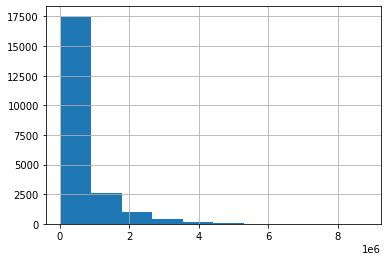

In [6]:
print(data.buy_price.describe())
data.buy_price.hist(bins=10)
plt.show()

The majority of the data is under 2000000€. The rest of the data is extremely skewed.

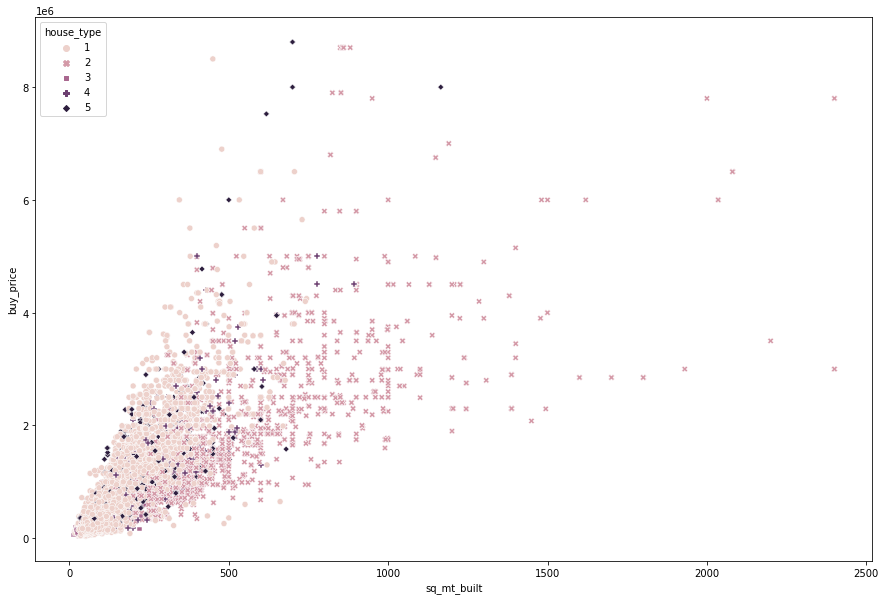

In [7]:
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(x='sq_mt_built', y='buy_price',hue='house_type', style='house_type',data=data)
plt.show()

We'll remove all houses over 4 million and over 1000 m². It's a small group but very scattered. About 281 houses, 1.3%.

This will allow us to reduce the errors' values.

In [8]:
data = data[data.buy_price < 4000000]
data = data[data.sq_mt_built < 1000]
data.describe()

sq_mt_built       n_rooms  ...    house_type     buy_price
count  21458.000000  21458.000000  ...  21458.000000  2.145800e+04
mean     143.464063      2.955494  ...      1.400923  6.035687e+05
std      127.488881      1.420207  ...      1.017621  6.294225e+05
min       13.000000      0.000000  ...      1.000000  3.600000e+04
25%       70.000000      2.000000  ...      1.000000  1.961600e+05
50%      100.000000      3.000000  ...      1.000000  3.690000e+05
75%      160.000000      4.000000  ...      1.000000  7.450000e+05
max      999.854545     15.000000  ...      5.000000  3.990000e+06

[8 rows x 15 columns]

We split the data into three groups train, validation and test.

In [9]:
train_x, test_x = train_test_split(data, test_size=0.2, random_state=15)
train_x, val_x = train_test_split(train_x, test_size=0.2, random_state=15)
print("{} train examples".format(len(train_x)))
print("{} val examples".format(len(val_x)))
print("{} test examples".format(len(test_x)))

13732 train examples
3434 val examples
4292 test examples


In [10]:
train_stats = train_x.describe().transpose()
train_stats

count           mean  ...       75%           max
sq_mt_built         13732.0     143.528390  ...     160.0  9.998545e+02
n_rooms             13732.0       2.956889  ...       4.0  1.400000e+01
n_bathrooms         13732.0       2.037140  ...       2.0  1.400000e+01
n_floors            13732.0       1.213589  ...       1.0  5.000000e+00
sq_mt_allotment     13732.0      38.744611  ...       0.0  5.000000e+03
floor               13732.0       1.892514  ...       4.0  1.000000e+01
is_renewal_needed   13732.0       0.181838  ...       0.0  1.000000e+00
has_lift            13732.0       0.690504  ...       1.0  1.000000e+00
is_exterior         13732.0       0.917419  ...       1.0  1.000000e+00
energy_certificate  13732.0       1.133411  ...       3.0  7.000000e+00
has_parking         13732.0       0.347364  ...       1.0  1.000000e+00
neighborhood        13732.0      62.971381  ...      95.0  1.350000e+02
district            13732.0       9.775051  ...      14.0  2.100000e+01
house_type          13732.0       1.397102  ...       1.0  5.000000e+00
buy_price           13732.0  604381.764200  ...  750000.0  3.990000e+06

[15 rows x 8 columns]

We normalize the data to speed up convergence.

In [11]:
def norm(x, stats):
    '''Normalize dataframe's columns using the mean and standard deviation for each one
       Parameters: Dataframe to normalize; Dataframe with statistics
       Return: The normalized dataframe '''
    
    return (x - stats['mean']) / stats['std']

train_xn = norm(train_x, train_stats)
val_xn = norm(val_x, train_stats)
test_xn = norm(test_x, train_stats)

We transform the dataframes into tensors that we shuffle and group into batches.

In [12]:
def data_tensor(df, shuffle=True, batch_size=64):
    '''Transforms a dataframe into a tensor object, shuffling the data and grouping it into batches.
       Parameters: Dataframe; shuffle option; batch size.
       Returns: A group of batch size's tensors'''
    
    df = df.copy()
    labels = df.pop('buy_price')
    ts = tf.data.Dataset.from_tensor_slices((df.values, labels.values))
    if shuffle:
        ts = ts.shuffle(buffer_size=len(df))
    ts = ts.batch(batch_size)
    return ts


In [13]:
train_ts = data_tensor(train_xn)
val_ts = data_tensor(val_xn)

# Model

In [14]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(14,)))
model.add(tf.keras.layers.Dense(264, activation=tf.nn.tanh))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.sigmoid))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(32, activation=tf.nn.tanh))
model.add(tf.keras.layers.Dense(16, activation=tf.nn.sigmoid))
model.add(tf.keras.layers.Dense(1))


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 264)               3960      
_________________________________________________________________
dropout (Dropout)            (None, 264)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               33920     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0

In [ ]:

optimizer = tf.keras.optimizers.Nadam()

model.compile(loss='mean_squared_error', optimizer=optimizer)


In [ ]:
lrr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                         patience = 50,
                         verbose = 1,
                         factor = 0.75,
                         min_lr = 1e-6)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=100,
                   restore_best_weights=True)


# Training

In [ ]:
history = model.fit(train_ts, validation_data=val_ts, epochs=500, callbacks=[lrr, es])

Epoch 1/500
215/215 [==============================] - 4s 8ms/step - loss: 0.4816 - val_loss: 0.3091
Epoch 2/500
215/215 [==============================] - 1s 6ms/step - loss: 0.2766 - val_loss: 0.2289
Epoch 3/500
215/215 [==============================] - 1s 6ms/step - loss: 0.2602 - val_loss: 0.2247
Epoch 4/500
215/215 [==============================] - 1s 6ms/step - loss: 0.2622 - val_loss: 0.2033
Epoch 5/500
215/215 [==============================] - 1s 6ms/step - loss: 0.2480 - val_loss: 0.1957
Epoch 6/500
215/215 [==============================] - 1s 6ms/step - loss: 0.2308 - val_loss: 0.1823
Epoch 7/500
215/215 [==============================] - 1s 6ms/step - loss: 0.2388 - val_loss: 0.1916
Epoch 8/500
215/215 [==============================] - 1s 6ms/step - loss: 0.2248 - val_loss: 0.1866
Epoch 9/500
215/215 [==============================] - 1s 6ms/step - loss: 0.2333 - val_loss: 0.1896
Epoch 10/500
215/215 [==============================] - 1s 6ms/step - loss: 0.2406 - val_lo

215/215 [==============================] - 1s 6ms/step - loss: 0.1528 - val_loss: 0.1321
Epoch 82/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1563 - val_loss: 0.1342
Epoch 83/500
215/215 [==============================] - 1s 7ms/step - loss: 0.1517 - val_loss: 0.1334
Epoch 84/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1436 - val_loss: 0.1347
Epoch 85/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1517 - val_loss: 0.1318
Epoch 86/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1424 - val_loss: 0.1355
Epoch 87/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1404 - val_loss: 0.1343
Epoch 88/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1490 - val_loss: 0.1343
Epoch 89/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1527 - val_loss: 0.1319
Epoch 90/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1419 - val_loss: 

Epoch 161/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1173 - val_loss: 0.1282
Epoch 162/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1289 - val_loss: 0.1264
Epoch 163/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1217 - val_loss: 0.1289
Epoch 164/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1241 - val_loss: 0.1244
Epoch 165/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1221 - val_loss: 0.1320
Epoch 166/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1301 - val_loss: 0.1253
Epoch 167/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1284 - val_loss: 0.1275
Epoch 168/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1280 - val_loss: 0.1272
Epoch 169/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1276 - val_loss: 0.1237
Epoch 170/500
215/215 [==============================] - 1s 6ms/step - lo

215/215 [==============================] - 1s 6ms/step - loss: 0.1230 - val_loss: 0.1277
Epoch 240/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1131 - val_loss: 0.1244
Epoch 241/500
215/215 [==============================] - 1s 7ms/step - loss: 0.1158 - val_loss: 0.1255
Epoch 242/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1181 - val_loss: 0.1255
Epoch 243/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1189 - val_loss: 0.1271
Epoch 244/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1137 - val_loss: 0.1253
Epoch 245/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1184 - val_loss: 0.1259
Epoch 246/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1203 - val_loss: 0.1258
Epoch 247/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1220 - val_loss: 0.1268
Epoch 248/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1119 - v

Epoch 318/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1101 - val_loss: 0.1251
Epoch 319/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1114 - val_loss: 0.1272
Epoch 320/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1115 - val_loss: 0.1231
Epoch 321/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1064 - val_loss: 0.1255
Epoch 322/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1070 - val_loss: 0.1228
Epoch 323/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1124 - val_loss: 0.1268
Epoch 324/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1142 - val_loss: 0.1264
Epoch 325/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1054 - val_loss: 0.1247
Epoch 326/500
215/215 [==============================] - ETA: 0s - loss: 0.107 - 1s 6ms/step - loss: 0.1071 - val_loss: 0.1230
Epoch 327/500
215/215 [==========================

215/215 [==============================] - 1s 6ms/step - loss: 0.1026 - val_loss: 0.1226
Epoch 397/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1029 - val_loss: 0.1241
Epoch 398/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1019 - val_loss: 0.1254
Epoch 399/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1054 - val_loss: 0.1282
Epoch 400/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1048 - val_loss: 0.1229
Epoch 401/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1036 - val_loss: 0.1233
Epoch 402/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1031 - val_loss: 0.1230
Epoch 403/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1055 - val_loss: 0.1210
Epoch 404/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1081 - val_loss: 0.1227
Epoch 405/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1081 - v

Epoch 475/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1052 - val_loss: 0.1239
Epoch 476/500
215/215 [==============================] - 1s 6ms/step - loss: 0.0987 - val_loss: 0.1242
Epoch 477/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1005 - val_loss: 0.1225
Epoch 478/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1034 - val_loss: 0.1222
Epoch 479/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1044 - val_loss: 0.1216
Epoch 480/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1004 - val_loss: 0.1223
Epoch 481/500
215/215 [==============================] - 1s 6ms/step - loss: 0.0989 - val_loss: 0.1215
Epoch 482/500
215/215 [==============================] - 1s 6ms/step - loss: 0.1033 - val_loss: 0.1217
Epoch 483/500
215/215 [==============================] - 1s 5ms/step - loss: 0.1013 - val_loss: 0.1225
Epoch 484/500
215/215 [==============================] - 1s 6ms/step - lo

# Validation

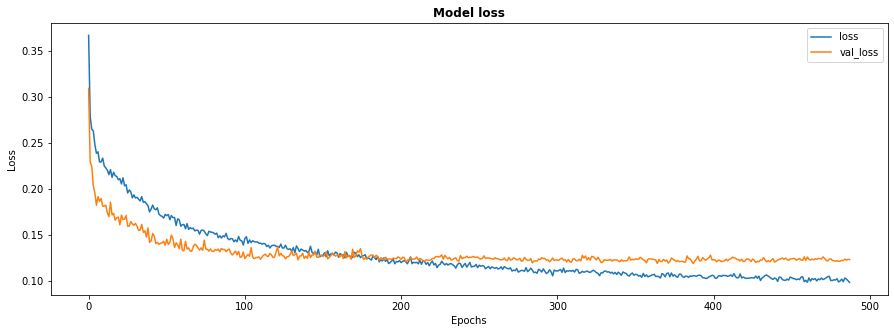

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(history.history['loss'], label='loss')

plt.plot(history.history['val_loss'], label='val_loss')


plt.title('Model loss', weight='bold')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

We managed a low error in the training and validation sets.

In [ ]:
def de_norm(x, stats, target):
    '''Transforms a normalized columns into its original values.
       Parameters: Column to transform; Dataframe with statistics, Target column's name
       Returns: Denormalized column'''
    
    return (x * stats.loc[target, 'std']) + stats.loc[target, 'mean']

In [ ]:
val_xn.pop('buy_price')

predict = de_norm(model.predict(val_xn).flatten(), train_stats, 'buy_price')
real_labels = val_x.buy_price
r2_score(real_labels, predict)

0.87781030701662

In [ ]:
test_xn.pop('buy_price')

predict_test = de_norm(model.predict(test_xn).flatten(), train_stats, 'buy_price')
test_labels = test_x.buy_price
r2_score(test_labels, predict_test)

0.8794868233787037

We obtained an accuracy of 88% for validation and test sets.

Let's check the results.

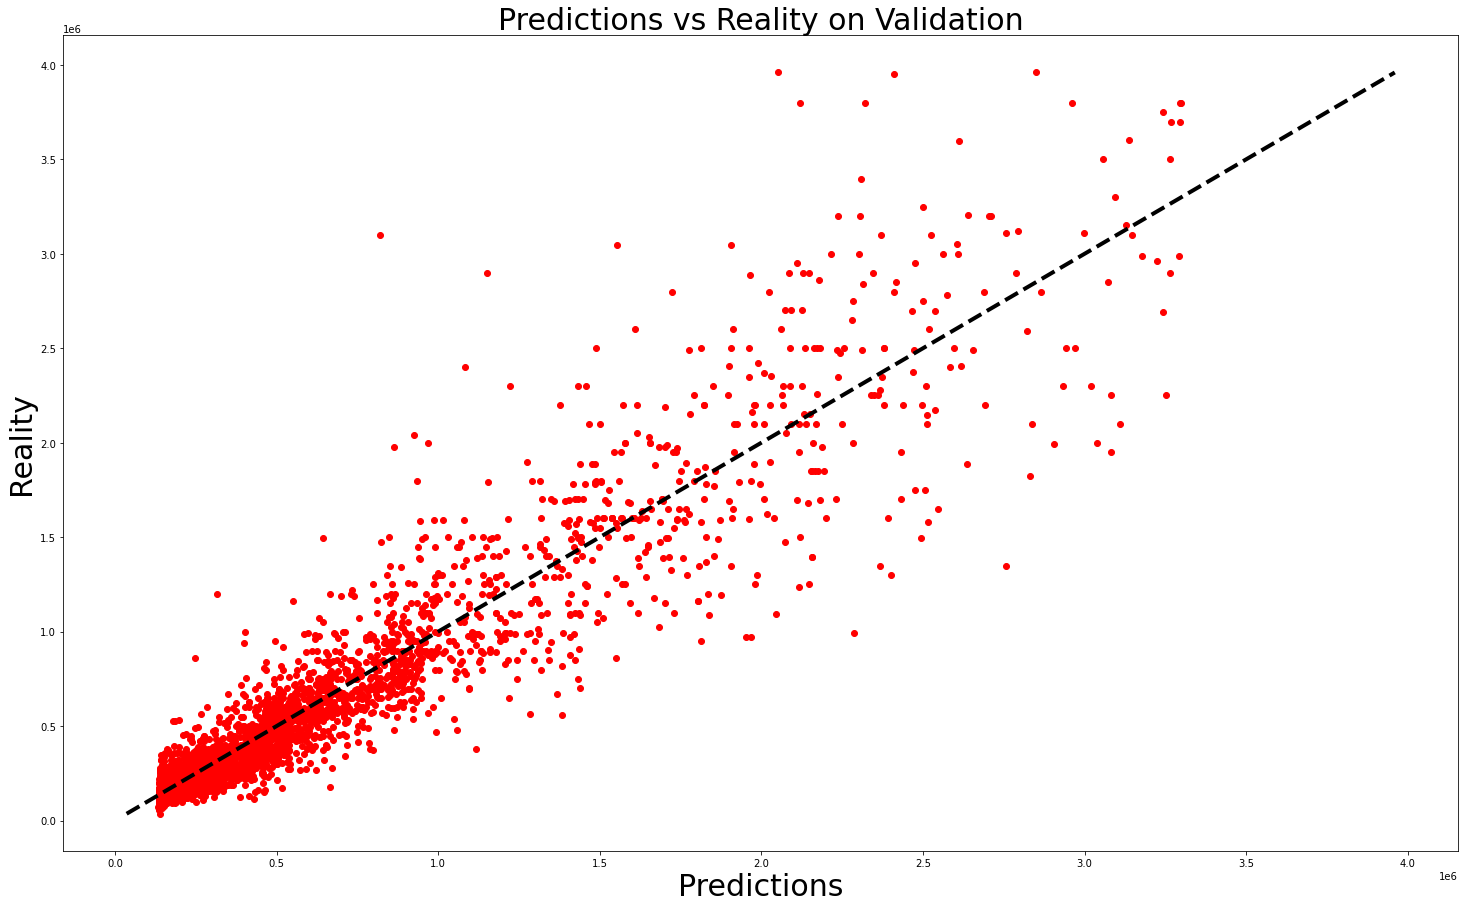

In [ ]:
fig, ax = plt.subplots(figsize=(25, 15))

plt.plot(predict, real_labels.values, 'ro')
plt.xlabel('Predictions', fontsize = 30)
plt.ylabel('Reality', fontsize = 30)
plt.title('Predictions vs Reality on Validation', fontsize = 30)
ax.plot([real_labels.min(), real_labels.max()], [real_labels.min(), real_labels.max()], 'k--', lw=4)
plt.show()

Over 1 million, points are more scattered. As we had seen, this is outlier's territory and it becomes more difficult to calculate the right price as we don't have enough examples.

# Error

In [ ]:
rel_val = val_x.copy()
rel_val['predicted'] = predict

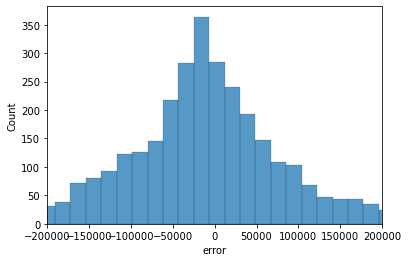

In [ ]:
rel_val['error'] = rel_val.buy_price - rel_val.predicted
sns.histplot(rel_val.error, bins=200)
plt.xlim(-200000, 200000)
plt.show()

The mode is small, less than 50000€ error per house.

Let's see how these errors are distributed.

We'll divide the error in two groups, those under 50000€ both positive (bellow correct price) and negative (above the correct price) and the rest.

In [ ]:
mode_error_small = rel_val.query('-50000 < error < 50000')
mode_error_small.describe()

sq_mt_built      n_rooms  n_bathrooms     n_floors  sq_mt_allotment  \
count  1468.000000  1468.000000  1468.000000  1468.000000      1468.000000   
mean     94.442098     2.544278     1.509537     1.074251         4.208447   
std      62.212710     1.139285     0.793148     0.356942        47.444512   
min      22.000000     0.000000     1.000000     1.000000         0.000000   
25%      61.000000     2.000000     1.000000     1.000000         0.000000   
50%      78.000000     3.000000     1.000000     1.000000         0.000000   
75%     106.250000     3.000000     2.000000     1.000000         0.000000   
max     714.000000    12.000000     7.000000     4.000000      1000.000000   

             floor     buy_price  is_renewal_needed     has_lift  is_exterior  \
count  1468.000000  1.468000e+03        1468.000000  1468.000000  1468.000000   
mean      2.094687  3.429949e+05           0.177112     0.620572     0.914169   
std       2.410757  3.313063e+05           0.381893     0.485410     0.280210   
min      -5.000000  8.800000e+04           0.000000     0.000000     0.000000   
25%       1.000000  1.517000e+05           0.000000     0.000000     1.000000   
50%       2.000000  2.250000e+05           0.000000     1.000000     1.000000   
75%       3.000000  4.300000e+05           0.000000     1.000000     1.000000   
max      10.000000  3.150000e+06           1.000000     1.000000     1.000000   

       energy_certificate  has_parking  neighborhood     district  \
count         1468.000000  1468.000000   1468.000000  1468.000000   
mean             1.097411     0.258856     68.645095    10.621935   
std              1.809441     0.438155     41.981705     6.204929   
min              0.000000     0.000000      1.000000     1.000000   
25%              0.000000     0.000000     31.000000     5.000000   
50%              0.000000     0.000000     67.000000    10.000000   
75%              2.000000     1.000000    112.250000    17.000000   
max              7.000000     1.000000    135.000000    21.000000   

        house_type     predicted         error  
count  1468.000000  1.468000e+03   1468.000000  
mean      1.288147  3.461527e+05  -3158.046130  
std       0.890422  3.286701e+05  26810.740484  
min       1.000000  1.350164e+05 -49977.500000  
25%       1.000000  1.506788e+05 -25023.328125  
50%       1.000000  2.226833e+05  -6486.343750  
75%       1.000000  4.351081e+05  18129.156250  
max       5.000000  3.147186e+06  49939.500000

In [ ]:
mode_error_big = rel_val[(rel_val.error < -50000)]
mode_error_big = mode_error_big.append(rel_val[(rel_val.error > 50000)])
mode_error_big.describe()

sq_mt_built      n_rooms  n_bathrooms     n_floors  sq_mt_allotment  \
count  1966.000000  1966.000000  1966.000000  1966.000000      1966.000000   
mean    177.890641     3.220753     2.416073     1.316378        66.954730   
std     146.586055     1.489265     1.446528     0.806845       289.629164   
min      23.000000     0.000000     1.000000     1.000000         0.000000   
25%      85.000000     2.000000     1.000000     1.000000         0.000000   
50%     128.000000     3.000000     2.000000     1.000000         0.000000   
75%     212.000000     4.000000     3.000000     1.000000         0.000000   
max     998.000000    15.000000     9.000000     5.000000      3000.000000   

             floor     buy_price  is_renewal_needed     has_lift  is_exterior  \
count  1966.000000  1.966000e+03        1966.000000  1966.000000  1966.000000   
mean      1.801628  7.908925e+05           0.185656     0.755341     0.919634   
std       3.375457  7.147718e+05           0.388928     0.429994     0.271928   
min      -5.000000  3.600000e+04           0.000000     0.000000     0.000000   
25%       1.000000  2.990000e+05           0.000000     1.000000     1.000000   
50%       2.000000  5.500000e+05           0.000000     1.000000     1.000000   
75%       4.000000  9.950000e+05           0.000000     1.000000     1.000000   
max      10.000000  3.960000e+06           1.000000     1.000000     1.000000   

       energy_certificate  has_parking  neighborhood     district  \
count          1966.00000  1966.000000   1966.000000  1966.000000   
mean              1.17294     0.434893     58.327060     9.076297   
std               1.95980     0.495869     35.045189     5.003335   
min               0.00000     0.000000      1.000000     1.000000   
25%               0.00000     0.000000     29.000000     5.000000   
50%               0.00000     0.000000     53.000000     8.000000   
75%               3.00000     1.000000     89.000000    13.000000   
max               7.00000     1.000000    135.000000    21.000000   

        house_type     predicted         error  
count  1966.000000  1.966000e+03  1.966000e+03  
mean      1.518820  7.955552e+05 -4.662332e+03  
std       1.131282  6.612137e+05  2.869807e+05  
min       1.000000  1.346548e+05 -1.407108e+06  
25%       1.000000  3.246040e+05 -1.328755e+05  
50%       1.000000  5.549484e+05 -6.046519e+04  
75%       1.000000  9.903695e+05  1.127772e+05  
max       5.000000  3.297743e+06  2.278481e+06

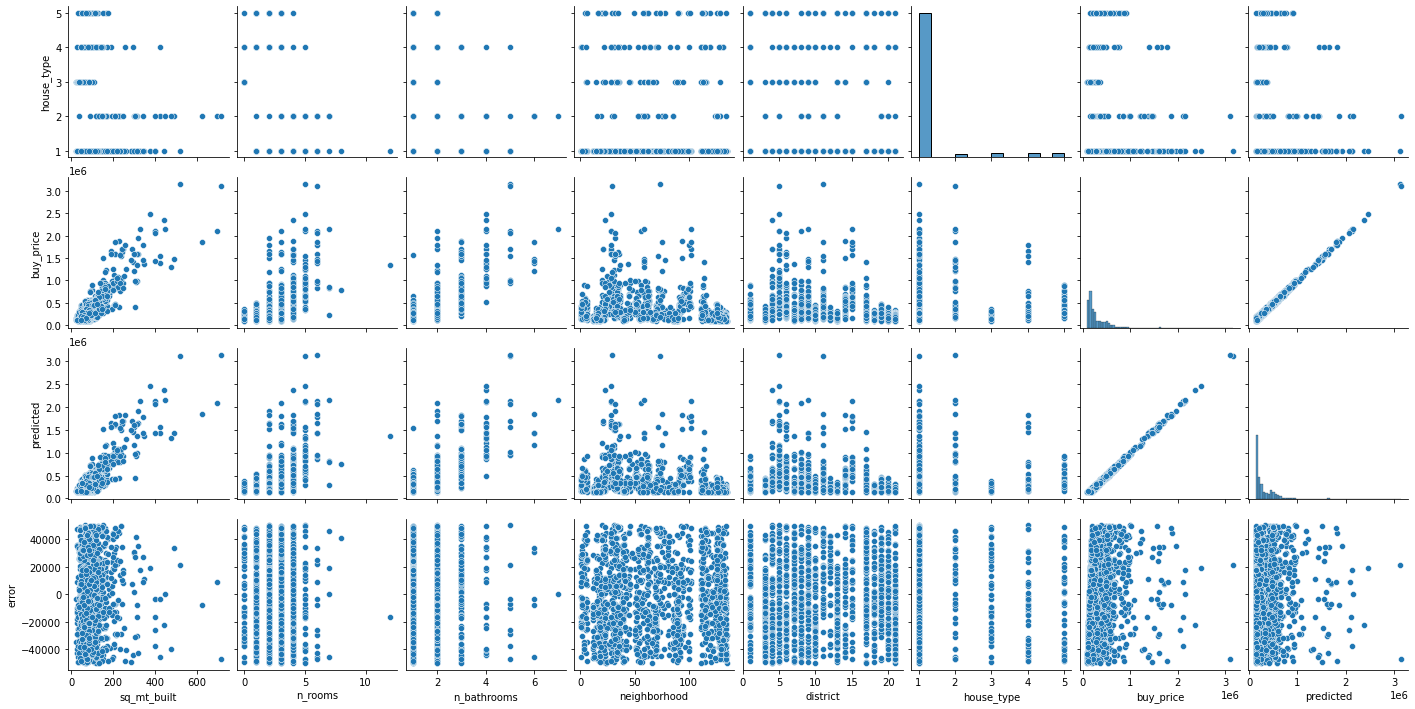

In [ ]:
sns.pairplot(data=mode_error_small, x_vars=['sq_mt_built', 'n_rooms','n_bathrooms', 'neighborhood', 'district', 'house_type', 'buy_price', 'predicted'],
            y_vars=['house_type', 'buy_price', 'predicted','error'])
plt.show()

Those with small errors are small houses, under 200 m². The prices' distributions are very similar. 

These errors are scattered among all neighborhoods, districts and specially flats.

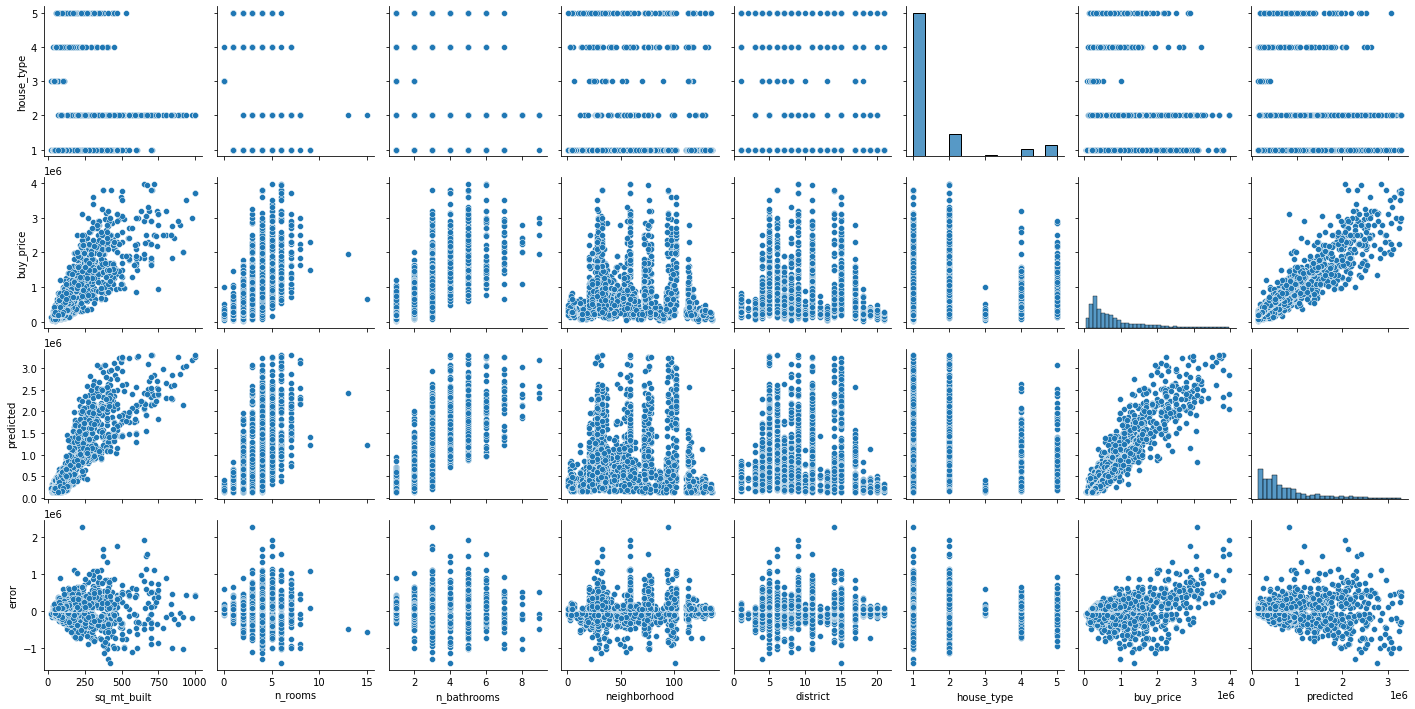

In [ ]:
sns.pairplot(data=mode_error_big, x_vars=['sq_mt_built', 'n_rooms','n_bathrooms', 'neighborhood', 'district', 'house_type', 'buy_price', 'predicted'],
            y_vars=['house_type', 'buy_price', 'predicted','error'])
plt.show()

With bigger errors, the prices' distributions are slightly different. The predicted price tends to be bigger than the correct one.

There are more 'houses' with this error, probably because they are the most expensive ones.

We can see the same effects on the other columns

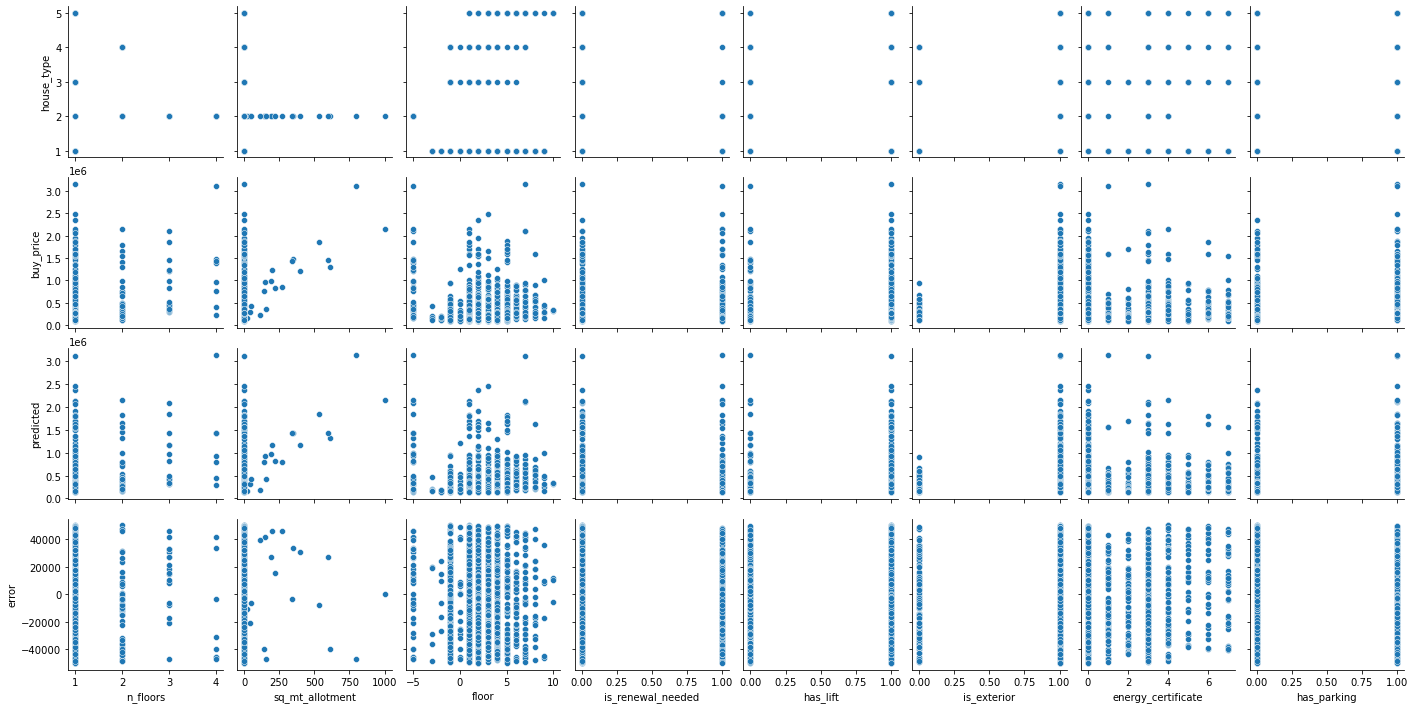

In [ ]:
sns.pairplot(data=mode_error_small, x_vars=['n_floors', 'sq_mt_allotment', 'floor','is_renewal_needed', 'has_lift','is_exterior','energy_certificate',
                                            'has_parking'], y_vars=['house_type', 'buy_price', 'predicted', 'error'])
plt.show()

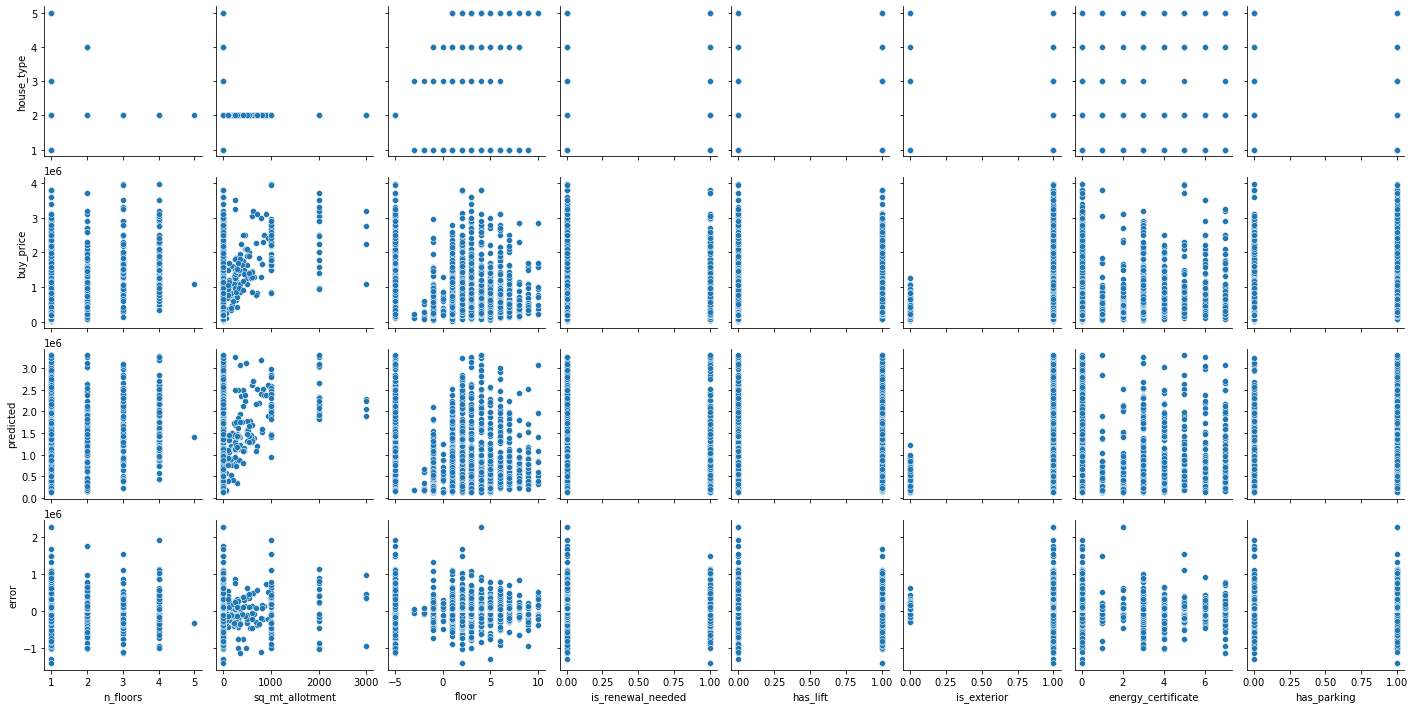

In [ ]:
sns.pairplot(data=mode_error_big, x_vars=['n_floors', 'sq_mt_allotment', 'floor','is_renewal_needed', 'has_lift','is_exterior','energy_certificate',
                                          'has_parking'], y_vars=['house_type', 'buy_price', 'predicted','error'])
plt.show()

If we analyse the kind of error, positive or negative, we find that there are, indeed, more negative errors (overpriced).

However,the biggest errors are positive. Possibly because there are very few houses with very high prices. The model can't adjust for these, essentially, outliers.

In [ ]:
rel_val.sort_values(by=['error'], ascending=False)

sq_mt_built  n_rooms  n_bathrooms  n_floors  sq_mt_allotment  floor  \
3950         230.0        3            3         1              0.0      4   
9680         650.0        5            5         4           1000.0     -5   
9622         466.0        5            3         2              0.0     -5   
11891        373.0        4            3         1              0.0      2   
6903         675.0        6            6         3           1000.0     -5   
...            ...      ...          ...       ...              ...    ...   
7095         918.0        6            8         2           2000.0     -5   
8749         570.0        3            3         3            800.0     -5   
14396        383.0        4            4         3            353.0     -5   
18479        409.0        4            3         1              0.0      5   
19988        422.0        6            4         1              0.0      2   

       buy_price  is_renewal_needed  has_lift  is_exterior  \
3950     3100000                  0         0            1   
9680     3960000                  0         0            1   
9622     2900000                  0         0            1   
11891    3800000                  0         1            1   
6903     3950000                  0         0            1   
...          ...                ...       ...          ...   
7095     2000000                  0         0            1   
8749     1300000                  0         0            1   
14396    1950000                  0         0            1   
18479     992000                  0         0            1   
19988    1350000                  1         1            1   

       energy_certificate  has_parking  neighborhood  district  house_type  \
3950                    2            1            94        14           1   
9680                    0            0            59         9           2   
9622                    0            0            59         9           2   
11891                   0            0            32         6           1   
6903                    5            1            75        11           2   
...                   ...          ...           ...       ...         ...   
7095                    4            1            76        11           2   
8749                    0            1            55         8           2   
14396                   7            0            31         5           2   
18479                   0            0            22         4           1   
19988                   0            1           101        15           1   

        predicted       error  
3950    821518.75  2278481.25  
9680   2052232.25  1907767.75  
9622   1150451.00  1749549.00  
11891  2118565.50  1681434.50  
6903   2409018.00  1540982.00  
...           ...         ...  
7095   3037706.75 -1037706.75  
8749   2402486.50 -1102486.50  
14396  3080829.00 -1130829.00  
18479  2286664.50 -1294664.50  
19988  2757108.00 -1407108.00  

[3434 rows x 17 columns]

In [ ]:
pos_error = rel_val.query('error > 0')
pos_error.error.count()

1503

In [ ]:
neg_error = rel_val.query('error < 0')
neg_error.error.count()

1931

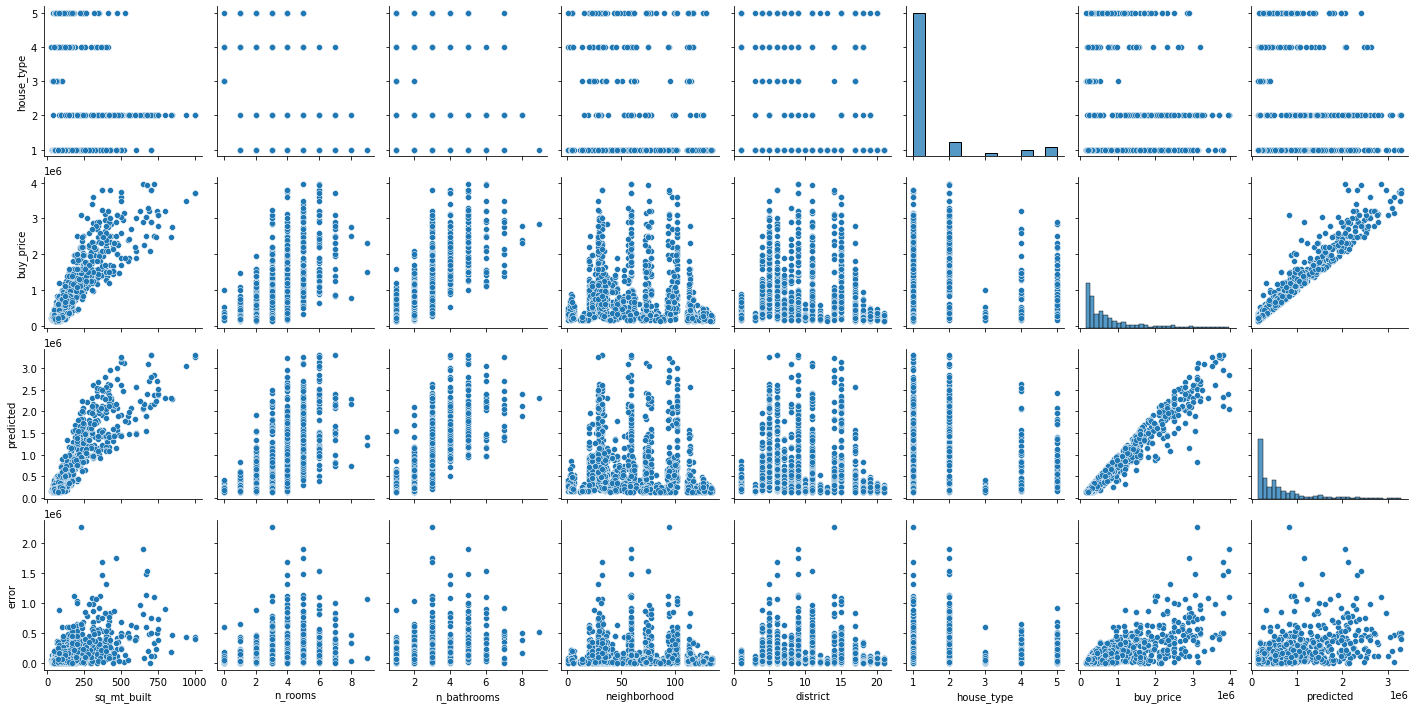

In [ ]:
sns.pairplot(data=pos_error, x_vars=['sq_mt_built', 'n_rooms','n_bathrooms', 'neighborhood', 'district', 'house_type', 'buy_price', 'predicted'],
            y_vars=['house_type', 'buy_price', 'predicted','error'])
plt.show()

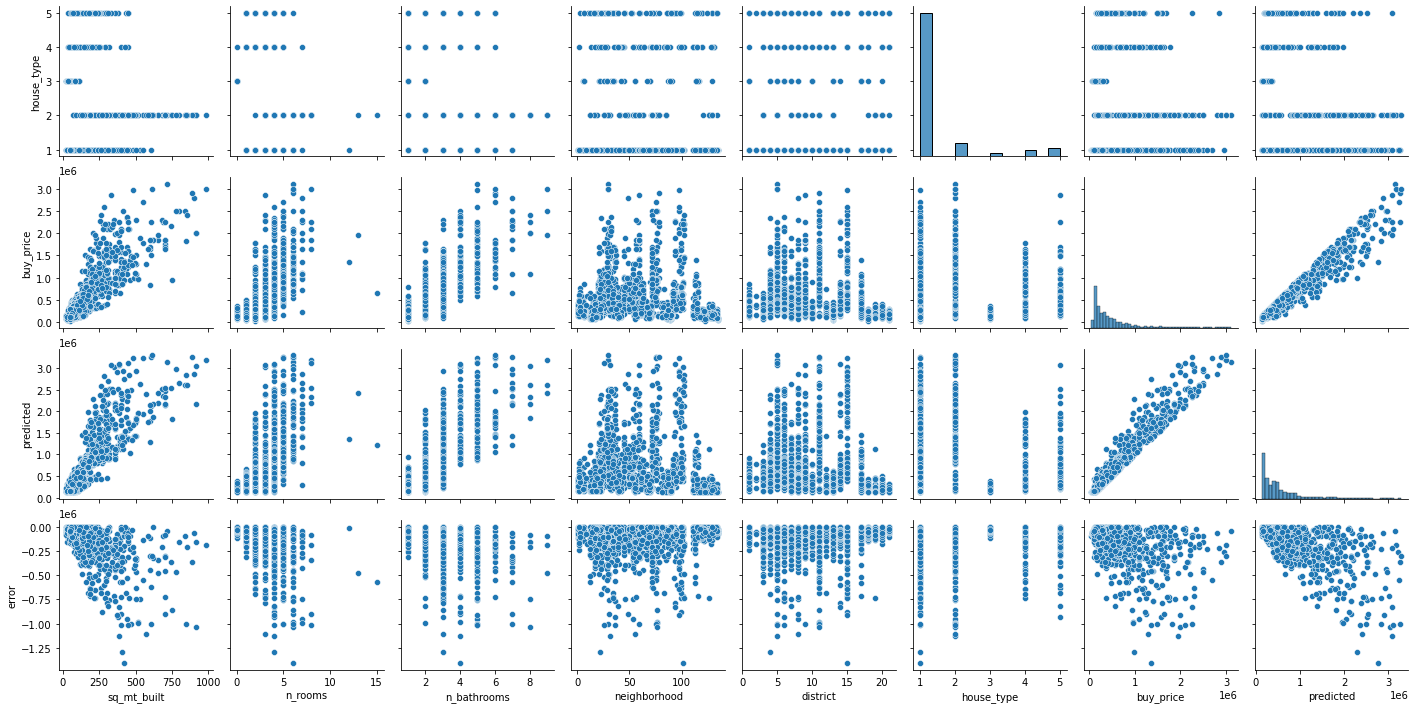

In [ ]:
sns.pairplot(data=neg_error, x_vars=['sq_mt_built', 'n_rooms','n_bathrooms', 'neighborhood', 'district', 'house_type', 'buy_price', 'predicted'],
            y_vars=['house_type', 'buy_price', 'predicted','error'])
plt.show()

Outliers are affecting the model's ability to predict prices. We'll apply some techniques to deal with them.